In [1]:
from PIL import Image
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from math import sqrt
from random import sample
from scipy.linalg import null_space
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 1.Fundamental matrix estimation

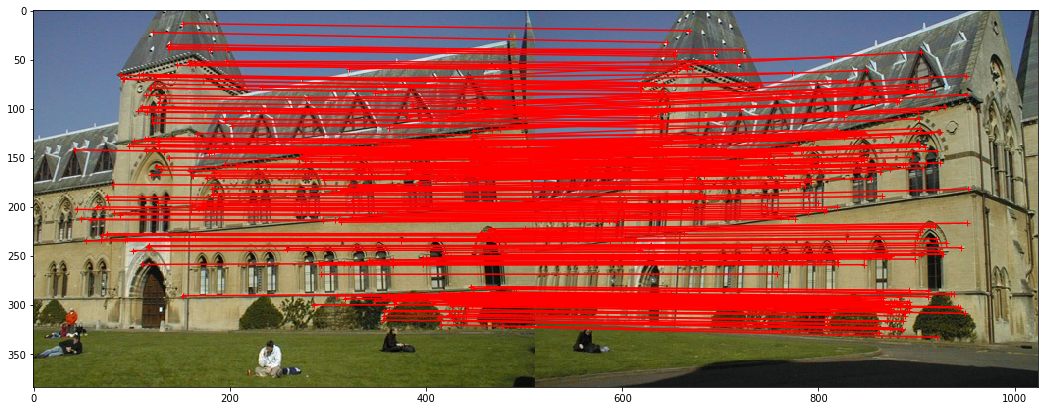

In [2]:
I1 = Image.open('library1.jpg')
I2 = Image.open('library2.jpg')
matches = np.loadtxt('library_matches.txt')
N = len(matches)
I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1
I3[:,I1.size[0]:,:] = I2
fig, ax = plt.subplots(figsize = (18,12))
ax.set_aspect('equal')
ax.imshow(np.array(I3/255).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

In [3]:
def normalize(matches):
    center = np.mean(matches, axis=0)
    dist = la.norm(matches - center, axis=1)
    mean = np.mean(dist)
    return np.array([[sqrt(2)/mean, 0, -sqrt(2)/mean*center[0]], 
                     [0, sqrt(2)/mean, -sqrt(2)/mean*center[1]], 
                     [0, 0, 1]])

In [4]:
def solve(left_matches, right_matches):
    n = left_matches.shape[0]
    M = np.zeros((n, 9))
    for i in range(n):
        u1, v1, u2, v2 =  left_matches[i][0],left_matches[i][1],right_matches[i][0],right_matches[i][1]
        M[i, 0] = u1 * u2
        M[i, 1] = v1 * u2
        M[i, 2] = u2
        M[i, 3] = u1 * v2
        M[i, 4] = v1 * v2
        M[i, 5] = v2
        M[i, 6] = u1
        M[i, 7] = v1
        M[i, 8] = 1

    U, S, V = la.svd(M)
    F = np.reshape(V[len(V) - 1], (3,3))
    F = F/F[-1, -1]
    U, S, V = la.svd(F)
    S = np.diag(S)
    S[-1, -1] = 0.
    return U.dot(S.dot(V))

In [5]:
def fit_fundamental(matches,if_normalize):
    N = matches.shape[0]
    left_matches = matches[:,:2]
    right_matches = matches[:,2:]
    if if_normalize == 1:
        T_left = normalize(left_matches)
        T_right = normalize(right_matches)
        left_matches = np.column_stack([left_matches,np.ones(N)])
        right_matches = np.column_stack([right_matches,np.ones(N)])
        normalized_left = (T_left.dot(left_matches.T)).T[:, :2]
        normalized_right = (T_right.dot(right_matches.T)).T[:, :2]
        F = solve(normalized_left, normalized_right)
        F = T_right.T.dot(F.dot(T_left))
    else:
        F = solve(left_matches, right_matches)
    left_matches = np.column_stack([matches[:,:2], np.ones(N)])
    right_matches = np.column_stack([matches[:,2:], np.ones(N)])
    epl = F.dot(left_matches.T).T
    dl = epl*left_matches
    epr = F.T.dot(right_matches.T).T
    dr = epr*right_matches
    dist = np.square(np.sum(dl, axis=1)/la.norm(epl[:, :2])) + np.square(np.sum(dr, axis=1)/la.norm(epr[:, :2]))
    residual = np.mean(dist)
    print('residual is:', residual)
    return F

residual is: 0.36843783647493566
Fundamental Matrix is: [[ 1.32546895e-06 -1.36852466e-05  6.83862987e-04]
 [ 2.88625175e-05 -2.66854091e-07 -4.09703775e-02]
 [-5.63235250e-03  3.73349826e-02  1.00000000e+00]]


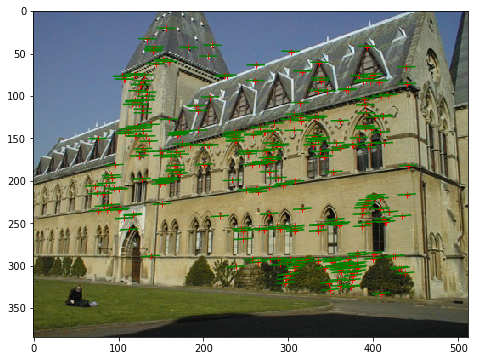

In [6]:
# First Image with unnormalized algorithm
F = fit_fundamental(matches, 0)
print('Fundamental Matrix is:',F)
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize = (8,6))
ax.set_aspect('equal')
ax.imshow(I2)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

residual is: 0.29983157155916923
Fundamental Matrix is: [[-2.23594578e-06  4.76632756e-05 -7.21267703e-03]
 [-2.89338411e-04 -2.97344169e-06  5.37233895e-01]
 [ 6.90565496e-02 -4.82492964e-01 -1.30678945e+01]]


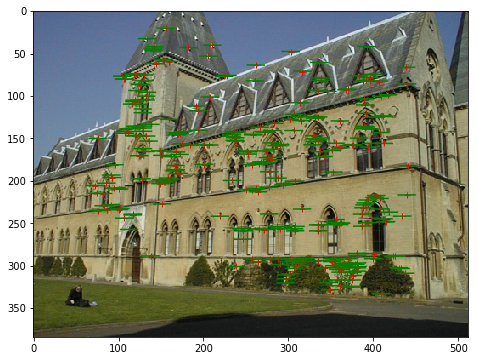

In [7]:
# First Image with normalized algorithm
N = len(matches)
F = fit_fundamental(matches, 1)
print('Fundamental Matrix is:',F)
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize = (8,6))
ax.set_aspect('equal')
ax.imshow(I2)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

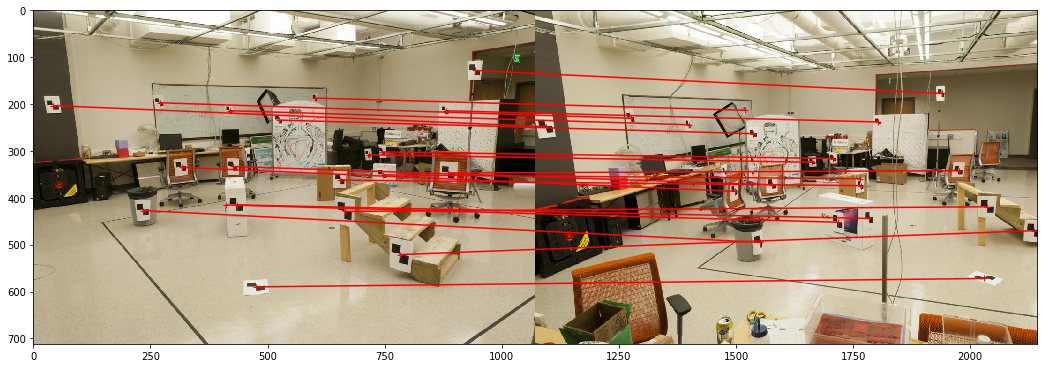

In [8]:
I1 = Image.open('lab1.jpg')
I2 = Image.open('lab2.jpg')
matches = np.loadtxt('lab_matches.txt')
N = len(matches)
I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1
I3[:,I1.size[0]:,:] = I2
fig, ax = plt.subplots(figsize = (18,12))
ax.set_aspect('equal')
ax.imshow(np.array(I3/255).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()

residual is: 146.20127244224392
Fundamental Matrix is: [[-5.36532415e-07  7.90760078e-06 -1.88694534e-03]
 [ 8.83981093e-06  1.21382365e-06  1.72419095e-02]
 [-9.07836099e-04 -2.64366809e-02  1.00000000e+00]]


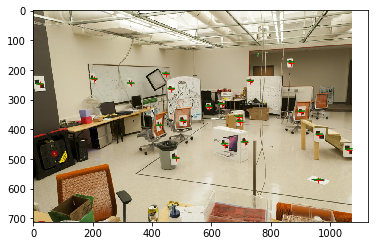

In [9]:
N = len(matches)
F = fit_fundamental(matches, 0)
print('Fundamental Matrix is:',F)
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(I2)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

residual is: 148.71702508275635
Fundamental Matrix is: [[ 7.43417253e-06 -1.01955354e-04  2.54830139e-02]
 [-7.04876785e-05  1.73505052e-05 -2.04960406e-01]
 [ 1.49163362e-03  2.81707911e-01 -6.55494956e+00]]


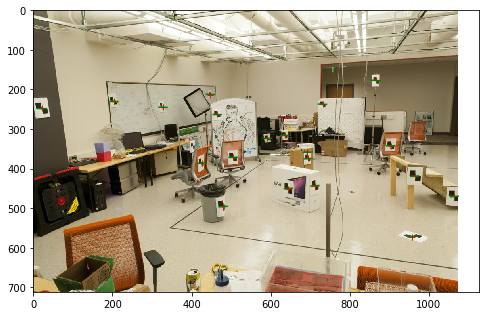

In [10]:
N = len(matches)
F = fit_fundamental(matches, 1)
print('Fundamental Matrix is:',F)
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize = (8,6))
ax.set_aspect('equal')
ax.imshow(I2)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

# 2.Camera calibration

In [11]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [12]:
def solve_projection(point3d, point2d):
    n = point3d.shape[0]
    M = np.zeros((n*2, 12))
    point3d = np.column_stack([point3d, np.ones(n)])
    
    for i in range(n):
        x3d = point3d[i]
        x = point2d[i, 0]
        y = point2d[i, 1]
        M[2*i, 4:8] = x3d
        M[2*i, 8:12] = -y*x3d
        M[2*i + 1, 0:4] = x3d
        M[2*i + 1, 8:12] = -x*x3d
    U, S, V = np.linalg.svd(M)
    H = V[len(V) - 1].reshape(3, 4)
    return H/H[-1, -1]

In [13]:
left = matches[:, :2]
right = matches[:, 2:]
point_3d = np.loadtxt('lab_3d.txt')
H_left_lab = solve_projection(point_3d, left)
H_right_lab = solve_projection(point_3d, right)
pt3d_left_lab, rss_left_lab = evaluate_points(H_left_lab, left, point_3d)
print('Projection matrix of camera 1 is', H_left_lab)
print('Residual of camera 1 is', rss_left_lab)
pt3d_right_lab, rss_right_lab = evaluate_points(H_right_lab, right, point_3d)
print('Projection matrix of camera 2 is', H_right_lab)
print('Residual of camera 2 is', rss_right_lab)


H_left_library = np.loadtxt('library1_camera.txt')
H_right_library = np.loadtxt('library2_camera.txt')
print('Projection matrix of camera 1 is', H_left_library)
print('Projection matrix of camera 2 is', H_right_library)

Projection matrix of camera 1 is [[-2.33260962e+00 -1.10025080e-01  3.37513233e-01  7.36686567e+02]
 [-2.31044166e-01 -4.79515070e-01  2.08722206e+00  1.53627263e+02]
 [-1.26377057e-03 -2.06774255e-03  5.14712341e-04  1.00000000e+00]]
Residual of camera 1 is 13.545832904282339
Projection matrix of camera 2 is [[-2.04586455e+00  1.18558243e+00  3.91381081e-01  2.44002874e+02]
 [-4.56804042e-01 -3.02392053e-01  2.14706068e+00  1.66030240e+02]
 [-2.24595257e-03 -1.09488059e-03  5.61389950e-04  1.00000000e+00]]
Residual of camera 2 is 15.544953444293107
Projection matrix of camera 1 is [[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
Projection matrix of camera 2 is [[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]

# 3.Calculate the camera centers

In [28]:
center = null_space(H_left_library)
center_left_library = center/center[-1]
print('The camera center of left lab is:', center_left_library)
center = null_space(H_right_library)
center_right_library = center/center[-1]
print('The camera center of right lab is:', center_right_library)
center = null_space(H_left_lab)
center_left_lab = center/center[-1]
print('The camera center of left library is:', center_left_lab)
center = null_space(H_right_lab)
center_right_lab = center/center[-1]
print('The camera center of right library is:', center_right_lab)

The camera center of left lab is: [[  7.28863053]
 [-21.52118112]
 [ 17.73503585]
 [  1.        ]]
The camera center of right lab is: [[  6.89405488]
 [-15.39232716]
 [ 23.41498687]
 [  1.        ]]
The camera center of left library is: [[305.83276769]
 [304.20103826]
 [ 30.13699243]
 [  1.        ]]
The camera center of right library is: [[303.10003925]
 [307.18428016]
 [ 30.42166874]
 [  1.        ]]


# 4.Triangulation

In [29]:
def triangulate(P_left, P_right, matches):
    num_match = matches.shape[0]
    kp1 = np.concatenate((matches[:, :2], np.ones((num_match, 1))), axis=1)
    kp2 = np.concatenate((matches[:, 2:], np.ones((num_match, 1))), axis=1)
    
    X = np.zeros((num_match, 4))
    for i in range(num_match):
        xi1 = np.array([[0, -kp1[i, 2], kp1[i, 1]],
                        [kp1[i, 2], 0, -kp1[i, 0]],
                        [-kp1[i, 1], kp1[i, 0], 0]])
        xi2 = np.array([[0, -kp2[i, 2], kp2[i, 1]],
                        [kp2[i, 2], 0, -kp2[i, 0]],
                        [-kp2[i, 1], kp2[i, 0], 0]])  
        
        A1 = np.matmul(xi1, P_left)
        A2 = np.matmul(xi2, P_right)
        A = np.vstack((A1, A2))

        _, _, V = np.linalg.svd(A)
        temp = V[len(V)-1]
        X[i] = temp / temp[-1]
    return X

In [43]:
def plot_3D(pt3d, center_left, center_right):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pt3d[:, 0], pt3d[:, 1], pt3d[:, 2], c='y', marker='o')
    ax.scatter(center_left[0], center_left[1], center_left[2], c='b', marker='x')
    ax.scatter(center_right[0], center_right[1], center_right[2], c='r', marker='x')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

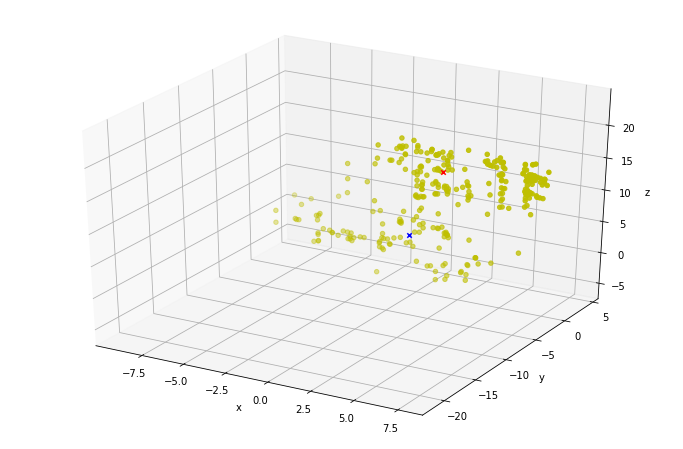

In [44]:
matches = np.loadtxt('library_matches.txt')    
P_left = H_left_library
P_right = H_right_library
X = triangulate(P_left,P_right,matches)
plot_3D(X,center_left_library, center_right_library)

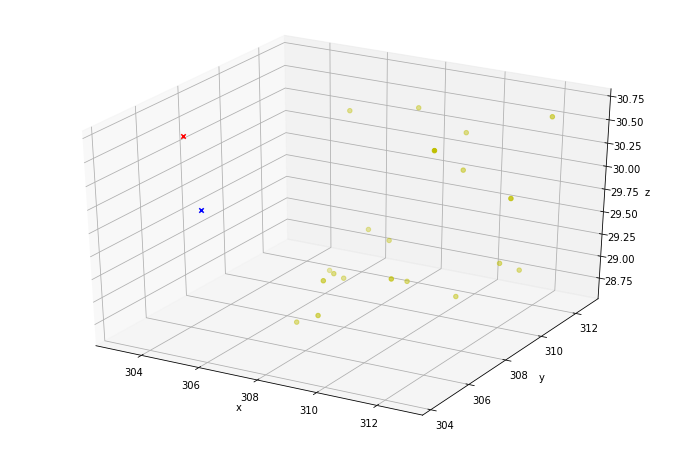

In [45]:
matches = np.loadtxt('lab_matches.txt')    
P_left = H_left_lab
P_right = H_right_lab
X = triangulate(P_left,P_right,matches)
plot_3D(X,center_left_lab, center_right_lab)